## Inversion einer Gleichstrom-Geoelektrik-Messung 

Mithilfe dieses Programms können Sie für gemessene Sondierungskurven eine Widerstandstiefenverteilung invertieren. Die prinzipielle Vorgehensweise der Inversion wird im Folgenden kurz erklärt. 

Grundlage einer jeden Inversion sind eine Reihe von Messdaten *d* (in diesem Fall ihre Auslagenlängen und Spannungs- und Stromstärkenmessungen) sowie ein Startmodell *m*. Das Startmodell sollte per Hand gewählt werden. In der Gleichstromgeoelektrik geht dies recht einfach anhand der Form der Messkurve. 

Als nächstes wird mithilfe des Modells eine *Vorwärtsrechnung* durchgeführt, d.h. es wird  für dieses Modell die Widerstands-Tiefenverteilung berechnet. Diesen Schritt kennen Sie bereits aus der letzten Übungsgaufgabe. Anschließend wird der Unterschied zwischen Daten und Modellantwort berechnet. Dieser Fehler wird häufig *misfit* genannt und mit $\delta$ abgekürzt. 

Nun beginnt die eigentliche Inversion. Wir addieren zu unserem Modell *m* eine kleine (in diesem Fall zufällige) Modellveränderung $\Delta$m und erhalten ein neues Modell m$_{new}$. Auch für dieses Modell berechnen wir eine Vorwärtsrechnung und den Unterschied/*misfit* zwischen Daten und Modell und erhalten ein neues $\delta_{new}$ für unser neues Modell. 

Anschließend vergleichen wir $\delta_{new}$ und $\delta$. Hier gibt es zwei Möglichkeiten. 

- 1. $\delta_{new}$ ist kleiner als $\delta$, d.h. das neue Modell passt die Messdaten besser an, als das alte. Wir übernehmen deshalb das neue Modell und vergessen das alte Modell und gehen wieder zum ersten Schritt der Inversion, und berechnen ein neues Modellupdate.
- 2. $\delta_{new}$ ist größer als $\delta$, d.h. das neue Modell passt die Messdaten schlecher an. Dann vergessen wir das neue Modell und behalten das alte Modell und gehen wieder zum ersten Schritt der Inversion, und berechnen ein neues zufälliges Modellupdate, in der Hoffnung, dass dieses die Daten dann besser anpasst. 

Auf diese Weise kann die Modellanpassung auschließlich besser werden oder gleich bleiben. 


Dieser Kreislauf wird eine *Iteration* der Inversion genannt. Wir wiederholen diese Schritte solange bis eine maximale Anzahl von Iterationen, die wir zuvor definieren müssen, erreicht ist. Dann speichern wir uns das letzte Modell als unser finales Modell, welche die Daten bestmöglich anpasst. 

Das folgende Organigramm fasst nochmal die wichtigsten Schritte der Inversion zusammen. 

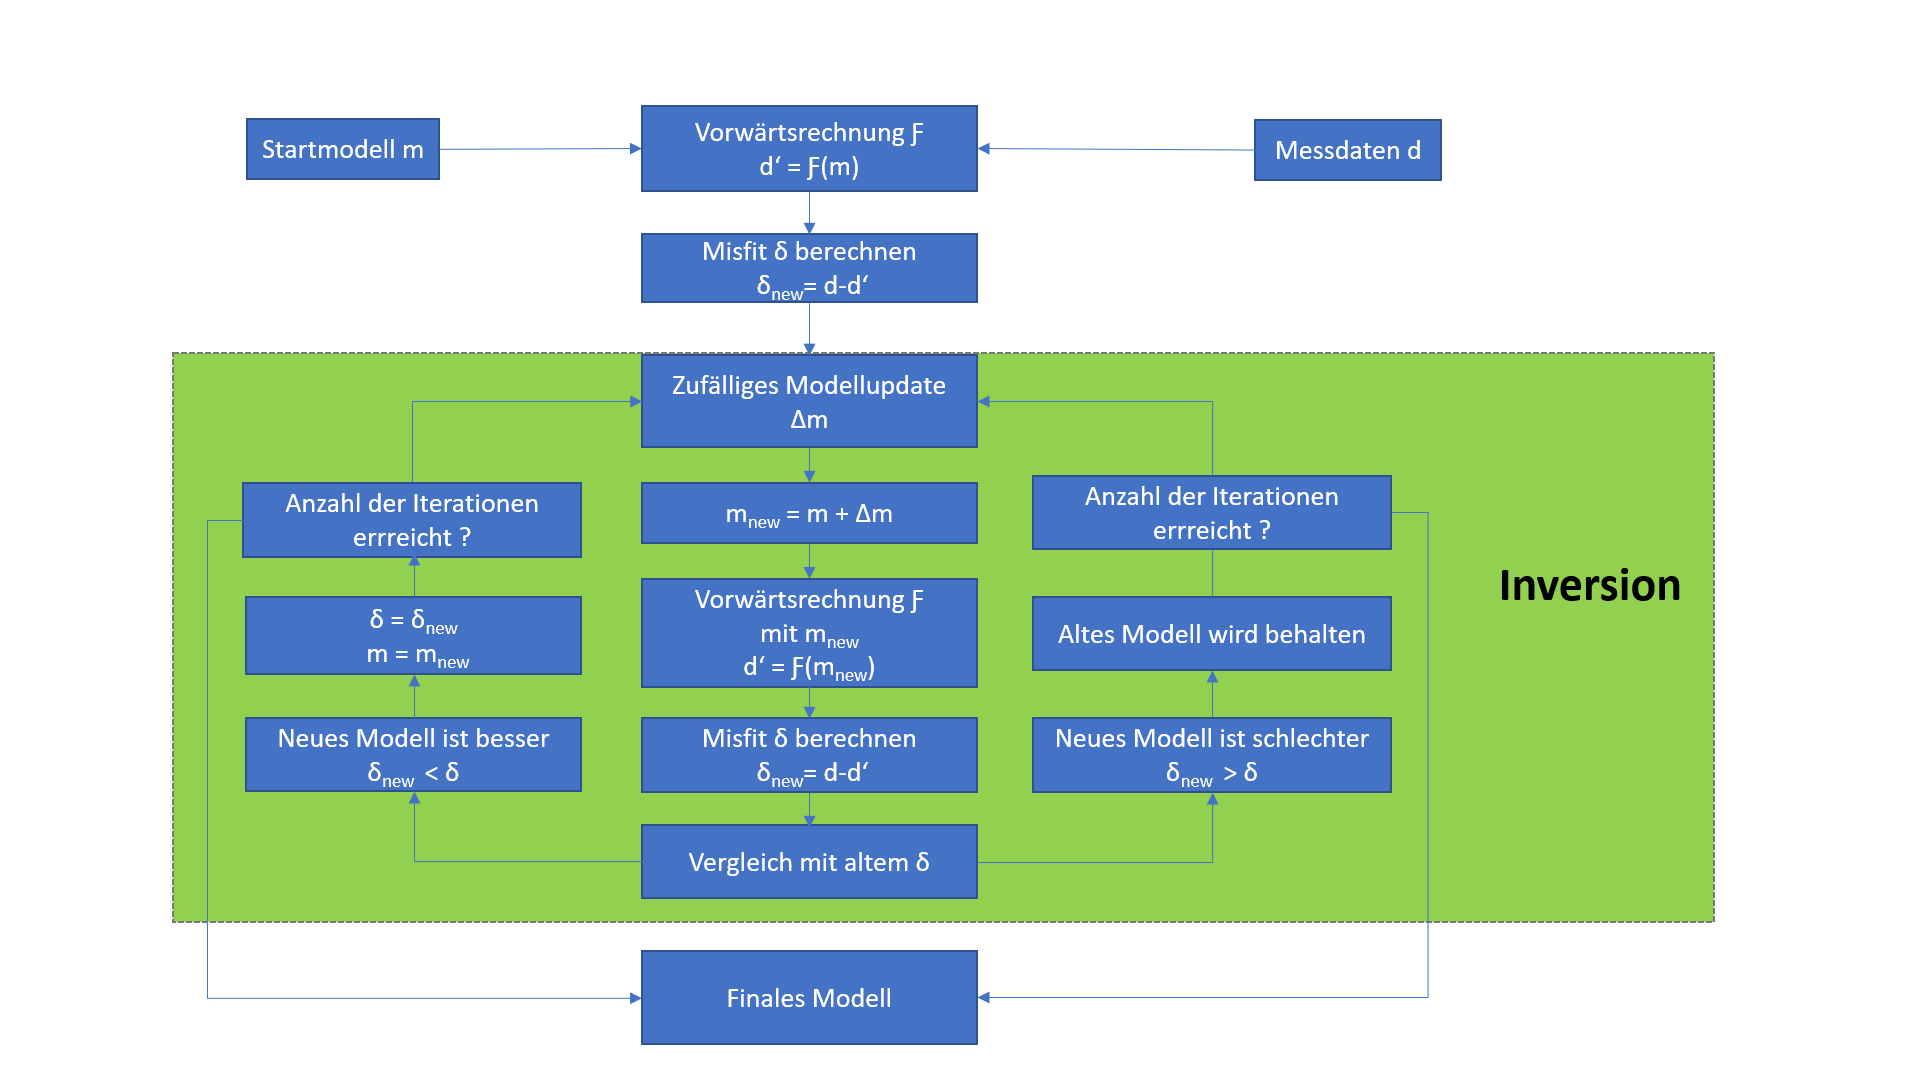

In [1]:
import numpy as np
import scipy.special as scp
import matplotlib.pyplot as plt
import time
 
''' Berechnet die scheinbaren spezifischen Widerstände für Schichten mit der
    Dicke d und spezifischen Widerständen rho für bestimmte Auslagenlängen L/2 

    © Nepomuk Boitz, Mai 2020, boitz@geophysik.fu-berlin.de
'''

def precompute_bessel_function(L_model,dx,n_max):
    vec = np.arange(0,n_max+dx,dx); 
    bessel = np.zeros([len(L_model),len(vec)])
    for jdx,L in enumerate(L_model):
        for idx,lamb in enumerate(vec):
            bessel[jdx,idx] = scp.jv(1,lamb*L)*lamb
    return bessel

def forward_model_1(rho,d,L_model,bessel,dx,n_max): 

    ## Initialize parameters
    n = len(rho); 
    K = np.zeros([n]); 
    T = np.zeros([n])
    vec1 = np.arange(0,n_max+dx,dx); 
    T_star = np.zeros(len(vec1))
    P = np.zeros([n-1])
    rho_a = np.zeros([len(L_model)])
    temp = np.zeros([n-1,len(vec1)])
    check = np.zeros([n-1,len(vec1)])
    K[n-1] = 1; 
    # Precomputations
    for i in range(0,n-1):
        P[i] = rho[i]/rho[i+1]; 
        for idx,lamb in enumerate(vec1):
            temp[i,idx] = np.tanh(d[i]*lamb)

    vec = np.arange(n-2,-1,-1)
    count = 0; 
    for idx,lamb in enumerate(vec1):  
        for i in vec:
            K[i] = (K[i+1]+P[i]*temp[i,idx])/(P[i] + K[i+1]*temp[i,idx]);
            check[i,idx] = K[i]
        T_star[idx] = rho[0]*check[0,idx];
    
    
    # Forward Modeling     
    for jdx,L in enumerate(L_model):
        fac = 0;
        for idx,lamb in enumerate(vec1):
            fac = fac + (((T_star[idx]-rho[0])*bessel[jdx,idx])*dx);
        fac = rho[0]+L**2*fac; 
        rho_a[count] = fac;   
        count += 1; 

    return rho_a

def invert_model(n_realisation,it_max,start_model,data,dx,n_max):
    history = np.zeros([n_realisation,len(start_model)+1])
    bessel = precompute_bessel_function(data[:,0],dx,n_max)
    n_layer = len(start_model)//2+1
    t_start = time.time()
    for j in range(n_realisation):
        rho = start_model[range(0,len(start_model)//2+1)]; 
        d = start_model[range(len(start_model)//2+1,len(start_model))]; 
        rho_a = forward_model_1(rho,d,data[:,0],bessel,dx,n_max);
        if j == 0:
            plot_single_model(data,rho_a)
            plt.title('Datenanpassung des Startmodells')
            
        misfit = np.linalg.norm(np.log10(rho_a)  - np.log10(data[:,2]),2); 
        mis = np.zeros(it_max)
        a = time.time()
        for i in range(it_max):
            rho_update = np.random.randn(n_layer)*fac*rho;
            d_update =np.random.randn(n_layer-1)*fac*d;
            rho_a = forward_model_1(rho+rho_update,d+d_update,data[:,0],bessel,dx,n_max);
            mis[i] = np.linalg.norm(np.log10(rho_a)  - np.log10(data[:,2]),2);
            if (mis[i] < misfit):
                misfit = mis[i];
                rho  = rho+rho_update;
                d = d+d_update;
        history[j,:] = np.concatenate([rho, d,np.array( [mis[i]])]);
        t_end = time.time()
        print('Berechnet Modell %d von insgesamt %d Modellen, durchschnittliche Berechnungsgzeit pro Modell %.2f s' % (j+1,n_realisation,(t_end-t_start)/(j+1)))
    return history

def plot_single_model(data,rho_a): 
    
    plt.loglog(data[:,0],data[:,2],'b.-')
    plt.loglog(data[:,0],rho_a,'r.-')
    plt.xlabel('L/2 [m]')
    plt.ylabel('scheinbarer spezifischer Widerstand [Ohm m]')
    plt.legend(['Data','Modell-Fit'])
    plt.title('Datenanpassung durch das beste invertierte Modell')
    
def plot_equivalent_models(history):
    fig, ax = plt.subplots(figsize=(8, 8),dpi=my_dpi)

    n_layer = np.size(history,1)//2
    for i in range(np.size(history,0)):
        z = np.zeros(2*n_layer)
        rho = np.zeros(2*n_layer)
        for j in range(n_layer):
            rho[range(j*2,j*2+2)] = history[i,j]
        for j in range(n_layer-1):
            z[range(j*2+1,j*2+3)] = history[i,n_layer+j] + z[j]
        z[n_layer*2-1] = 20
        plt.loglog(rho,z,'k--')
        if np.argmin(history[:,np.size(history,1)-1])==i:
            plt.loglog(rho,z,'r-')
    plt.gca().invert_yaxis()
    plt.ylabel('Tiefe [m]')
    plt.xlabel('Spezifischer Widerstand [Ohm m]')
    
    
    

### Inversionsprogramm

Geben Sie hier ihre von Hand berechneten Werte für die Auslagenlänge *L/2*, den Formationsfaktor *G* und ihre scheinbaren spezifischen Widerstände ein. 
Schätzen Sie anschließend ein mögliches Startmodell mit Schichtmächtigkeiten und spezifischen Widerständen ab.
Sie erhalten eine Abbildungen mit der Anpassung ihrer Daten durch das Startmodell und durch ihr bestes invertiertes Modell. Beachten Sie, dass Die Inversion je nach Einstellung einige Zeit in Anspruch nehmen kann. Eine Fortschrittsanzeige erscheint während der Berechnung. 

Berechnet Modell 1 von insgesamt 5 Modellen, durchschnittliche Berechnungsgzeit pro Modell 3.92 s
Berechnet Modell 2 von insgesamt 5 Modellen, durchschnittliche Berechnungsgzeit pro Modell 4.10 s
Berechnet Modell 3 von insgesamt 5 Modellen, durchschnittliche Berechnungsgzeit pro Modell 4.21 s
Berechnet Modell 4 von insgesamt 5 Modellen, durchschnittliche Berechnungsgzeit pro Modell 4.27 s
Berechnet Modell 5 von insgesamt 5 Modellen, durchschnittliche Berechnungsgzeit pro Modell 4.28 s


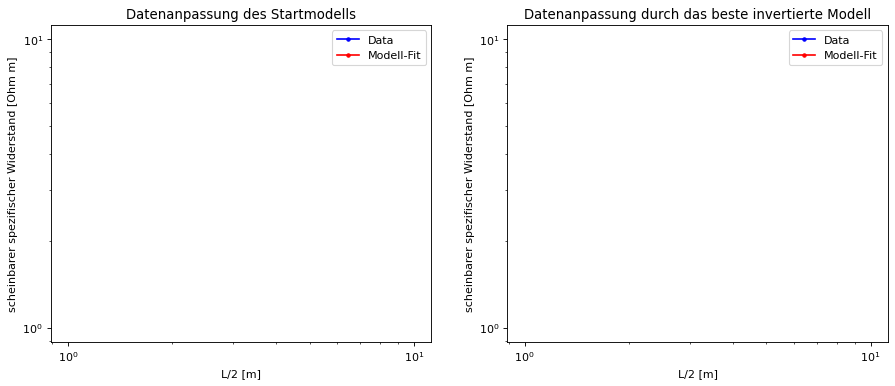

In [4]:
# Messwerte

L_halbe = np.array([])# Fügen sie innerhalb der eckigen Klammern ihre Messwerte, durch Kommata getrennt, ein. 
G = np.array([]) # Beachten Sie, dass Sie für Kommazahlen anstatt des Kommas den Punkt verwenden 
rho_a = np.array([]) # also z.B. 9.2 und nicht 9,2



# Startmodell
rho_start = np.array([500,20,100,10]); 
d_start = np.array([1,3,8]); 


# Inversionparameter
dx = .075 # Parameter für das numerische Lösen des Intergrals (am besten so lassen)
n_max = 30; # Paramter für das numerische Lösen des Intergrals (am besten so lassen)
fac = .15; # kontrolliert wie groß ein einzelnes Modellupdate sein soll
it_max = 400; # Anzahl der Modelle pro Iteration die getestet werden
n_realisation = 5; # Wie viele Equivalenzmodelle sollen berechnet werden ? 


# Inversion wird gestartet - Ab hier nichts mehr verändern

data = np.column_stack((L_halbe,G,rho_a))
start_model = np.concatenate([rho_start,d_start])
bessel = precompute_bessel_function(data[:,0],dx,n_max)
my_dpi = 80
plt.figure(figsize=(1080/my_dpi, 420/my_dpi), dpi=my_dpi)
plt.subplot(1,2,1)
history = invert_model(n_realisation,it_max,start_model,data,dx,n_max)

# Find best model 
plt.subplot(1,2,2)
which_model = np.argmin(history[:,np.size(history,1)-1])

# Plot best model
rho_final = history[which_model,range(0,np.size(history,1)//2)]; 
d_final = history[which_model,range(np.size(history,1)//2,np.size(history,1)-1)]; 
rho_a = forward_model_1(rho_final,d_final,data[:,0],bessel,dx,n_max)
plot_single_model(data,rho_a)

### Equivalenzmodelle 

Die folgende Abbildung zeigt die Widerstands-Tiefenverteilungen ihrer Equivalenzmodelle und das beste Modell in rot. 

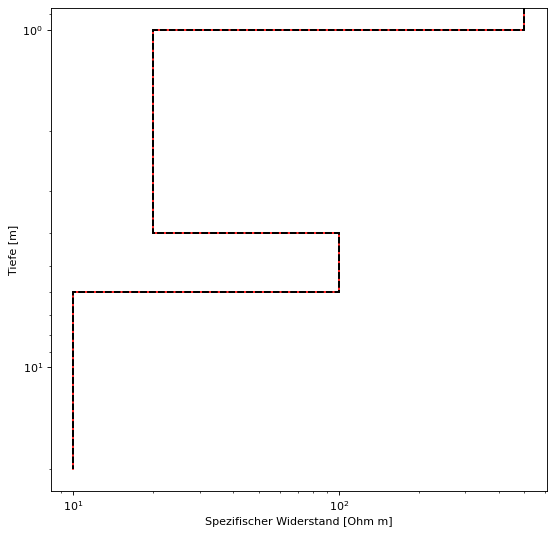

In [5]:
# Plot Equivalent-Models
plot_equivalent_models(history)